## RBFSampler actually is not using any Radial Basis Functions (RBFs)

done by [sy2002](http://www.sy2002.de) on 12th of April 2019, refined and documented on 17th of April 2019

#### Naive Assumption

While programming a
[Reinforcement Learning solution](https://github.com/sy2002/ai-playground/blob/master/rl-q-rbf-cartpole.py)
to the
[Inverse Pendulum problem](http://gym.openai.com/envs/CartPole-v1/),
I did not care, how
[RBFSampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html)
works under the hood in detail. Deducting from the name, I naively thought that it would do the following:

1. When fitting it using `RBFSampler.fit(...)`, it would use the samples given in the fit function for stochastically finding optimal centers (aka "Exemplars") for an amount of Radial Basis Functions (RBFs) as specified by the parameter `n_components` in the constructor of the RBFSampler.
2. When performing a feature transformation using `RBFSampler.transform(...)`, it would return the distances to all these Exemplars as new features.
3. ... well, just what you would expect from RBFs :-)

Spoiler alarm: It does not - but it still works, so it is kind of fair and valid to think about RBFSampler, as if it would be RBFs... ...read on to find out why.

#### RTFM - The scikit-learn team never claimed that RBFSampler would work like an RBF sampler

My naive assumption was not well-grounded. The scikit-learn manual states, that the RBFSampler class "approximates [the] feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform". And it even goes on mentioning that "it implements a variant of Random Kitchen Sinks" by pointing to the
[underlying paper](https://papers.nips.cc/paper/3182-random-features-for-large-scale-kernel-machines.pdf).
Pretty cryptic for a beginner like me. Investing a serious amount of time, I might have been able to understand this paper, but I was too impatient to work through it, so I tried Google and found another
[background article](http://www.argmin.net/2017/12/05/kitchen-sinks/)
on the topic. Unfortunatelly, this one also did not enlighten me.

Last but not least, also the
[Issue Tracker of scikit-learn Team](https://github.com/scikit-learn/scikit-learn/issues/4298#issuecomment-376812492)
mentions the phenomenon and reiterates on a topic that is also mentioned in the documentation: "Note that 'fitting' the feature function does not actually depend on the data given to the fit function. Only the dimensionality of the data is used."

So I began asking myself some questions:

* Why is RBFSampler called RBFSampler, when in reality it does "something else"?
* Why isn't it caring at all about the given data while fitting?
* Where does the algorithm take the centers from?
* Why can it return negative numbers (while RBFs cannot)?
* What is it actually doing?
* Is "something else" maybe mathmatically equivalent to RBFs, at least when it comes to the outcome in the context of machine learning - but in contrast to RBFs it is faster?

#### Creating an experiment to understand the nature of the beast

Let's assume the RBFSampler actually would use Radial Basis Functions (RBFs). If you would then use it in a two-dimensional (2D) space - a plane - then it would behave like this: Given a coordinate vector (x, y) in 2D space and one RBF centered at (cx, cy). Then the RBFSampler.transform([x, y]) function would output one floating point number, which would be something like the "distance" to the center of the RBF.
[Wikipedia](https://en.wikipedia.org/wiki/Radial_basis_function#Examples) is nicely illustrating this, for example for Gaussian RBFs.

The following code experiment is performing four steps and for each step, it paints the result as a 2D image, where high values of the RBF (or RBFSampler) are painted white and low values are painted black. The four steps are:

1. Manually implement a Gaussian RBF
2. Use RBFSampler with `n_components=1` to try to reproduce the same result as with the manual implementation
3. Repeat step (1) for 20 Gaussian RBFs with random centers
4. Repeat step (2) also with 20 centers / Exemplars using `n_components=20`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.kernel_approximation import RBFSampler

##### Step 1 - Manual RBF

Manually programmed RBF, visualized in 2D space.

In [4]:
# let's use len_x * len_y samples to draw the visualization.
len_x = 200
len_y = 200

# let's have the value space in our 2D example run from min_val to max_val
min_val = -2
max_val = +2

# * the image will be drawn by using matplotlib's imshow, which expects a 3d array/list of pixels
#   in the following form: [rows, columns, rgb-values]
# * so we generate a mesh grid that we can use to map the x, y values to colors in the
#   same order, as imshow needs it
# * since imshow draws from top/left to bottom/right, we need to make sure, that the y-axis
#   runs from max_val to min_val and in contrast the x-axis from min_val to max_val
# * the complex number syntax is just an oddity of numpy.mgrid - refer to the documentation
grid_y, grid_x = np.mgrid[max_val:min_val:complex(0, len_y), min_val:max_val:complex(0, len_x)]
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()

In [5]:
# Gaussian Radial Basis Function
# for example as defined here https://en.wikipedia.org/wiki/Radial_basis_function
def rbf(x, l, g):
    x = np.array(x)
    l = np.array(l)
    return np.exp(-(g * np.linalg.norm(x - l)**2))

In [6]:
# apply the RBF to our value spectrum ranging from min_val to max_val (e.g. from -2 to +2)
# and by doing so, generate the image that we want to show
image = []

for y, x in zip(grid_y, grid_x):
    X = [x, y]       # 2D vector for RBF
    C = [0.7, 0.7]   # center of the RBF
    image.append(3 * [rbf(X, C, 1.0)]) # RBF with gamma = 1.0

# hint: the above 3 * [] statement makes sure, that R, G and B color values are equal,
# so that the result will be a grayscale from black to white

In [7]:
# transform the flat image data into the [rows, columns, RGB] form that the imshow routine expects
image = np.array(image).reshape(len_y, len_x, 3)

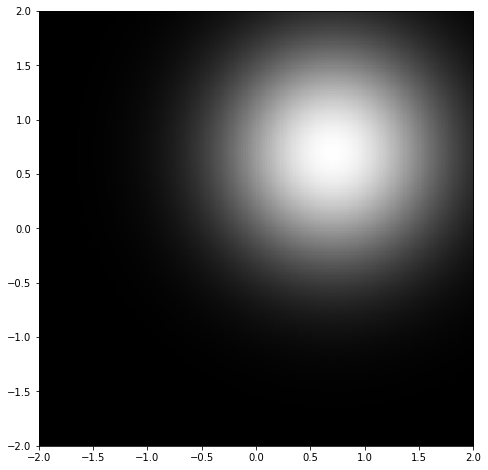

In [8]:
# draw the values of the feature transformation of the x, y coordinates to the RBF
plt.figure(figsize=(8, 8))
plt.imshow(image, extent=[min_val, max_val, min_val, max_val], interpolation="none")
plt.show()

Interpretation:

This is exactly what one would expect from a 2D feature transformation using an RBF: Depending on where the center point of the RBF is - in this example (0.7, 0.7) - and depending on the gamma value for the Gaussian distribution - in this example 1.0 - we get a circle shaped gradient that fades from black (0.0) to white (1.0).

##### Step 2 - Using RBFSampler with 1 Exemplar
Trying to reproduce the result from step (1) with RBFSampler.

In [9]:
# we are using just one exemplar / center by setting n_components to 1
# also note that we use the same gamma value as abve
rbfs = RBFSampler(gamma=1.0, n_components=1)

In [10]:
# reading the documentation shows, that the fit function does not consider the data at all, but only
# the dimensionality of the data, so we can pass some dummy numbers
rbfs.fit([[0, 0]])

RBFSampler(gamma=1.0, n_components=1, random_state=None)

In [11]:
# transformation function that takes into consideration, that rbf.transform returns an array with one
# element, so using "min" (or "max") extracts that; additionally and strangely enough, RBFSampler's transformation
# can also yield negative numbers
def rbf_distance(x, y):
    return np.min(rbfs.transform([[x, y]]))

In [12]:
# same visualization technique as above ...
image2 = []

for y, x in zip(grid_y, grid_x):
    image2.append(3 * [rbf_distance(x, y)])

image2 = np.array(image2).reshape(len_y, len_x, 3)

# ... but this time we need to make sure that the output is normalized to be between 0 and 1
# (something we would not have to do if RBFSampler actually behaved like RBFs)
image2 -= np.min(image2)  # make sure that all values are > 0
image2 /= np.max(image2)  # normalize between 0 .. 1

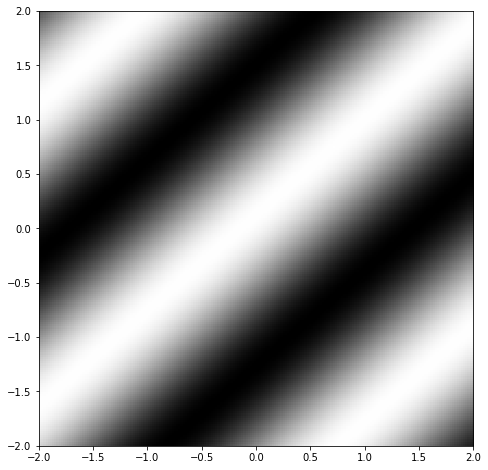

In [13]:
# draw it
plt.figure(figsize=(8, 8))
plt.imshow(image2, extent=[min_val, max_val, min_val, max_val], interpolation="none")
plt.show()

Interpretation:

In the source code of RBFSampler we see, that there is a projection and a cosine function:

https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/kernel_approximation.py#L126

This can explain the above-mentioned pattern in the image.

But unfortunatelly this can not explain my initial questions and at this stage, I would have wondered, how `RBFSampler` can be of any use in the context of RBFs.

##### Step 3 - Manually creating a "network" of 20 RBFs
Randomly find 20 centers for 20 RBFs and paint the resulting image by adding up the distances to each RBF center at each point of the plane.


In [23]:
EXEMPLARS = 20
Cs_GAMMA = 3.0

# create EXEMPLARS amount of centers that fit into min_val .. max_val
Cs = []
Cs_width = max_val - min_val
for i in range(EXEMPLARS):
    Cs.append([np.random.rand()*Cs_width - Cs_width/2.0, np.random.rand()*Cs_width - Cs_width/2.0, Cs_GAMMA])

In [24]:
# to visualize multiple RBFs, we are adding up all distances to all centers for the current pixel
def multi_rbf(x):
    ret_val = 0.0
    x = np.array(x)
    for c in Cs:
        l = [c[0], c[1]]
        ret_val += rbf(x, l, c[2])
    return ret_val

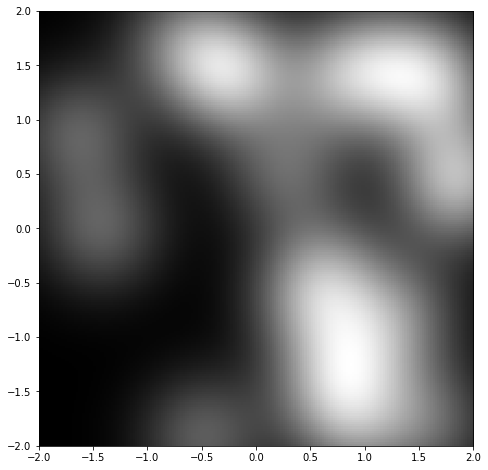

In [25]:
# plot using the technique described above in detail
image3 = []

for y, x in zip(grid_y, grid_x):
    image3.append(3 * [multi_rbf([x, y])])   
    
image3 = np.array(image3).reshape(len_y, len_x, 3)
image3 /= np.max(image3) # as we are adding up all RBFs distances, we need to normalize to 0 .. 1

plt.figure(figsize=(8, 8))
plt.imshow(image3, extent=[min_val, max_val, min_val, max_val], interpolation="none")
plt.show()

Interpretation:

Again, this is exactly what you would have expected: Due to the wide Gamma factor of 3.0 for the Gaussian RBF, we are seeing 20 (admittedly) pretty blurred circles that flow into each other.

##### Step 4 - Using RBFSampler with 20 Exemplars

In [26]:
rbfs2 = RBFSampler(gamma=Cs_GAMMA, n_components=EXEMPLARS)
rbfs2.fit([[0, 0]])

RBFSampler(gamma=3.0, n_components=20, random_state=None)

In [27]:
# similar mechanism as above: to visualize multiple RBFs, we are adding up all distances to all centers
# for the current pixel with the speciality, that we also have negative values here
def rbf_distance(x, y):
    return np.sum(rbfs2.transform([[x, y]]))

In [28]:
image4 = []

for y, x in zip(grid_y, grid_x):
    image4.append(3 * [rbf_distance(x, y)])

In [29]:
image4 = np.array(image4).reshape(len_y, len_x, 3)

# special post processing needed:
# we have potentially large negative values; by clipping them, the resulting image is "a bit less crowded"
image4 = np.clip(image4, np.min(image4)*0.4, 100)

# the usual "make all values positive and scale to 0 .. 1"
image4 -= np.min(image4)
image4 /= np.max(image4)

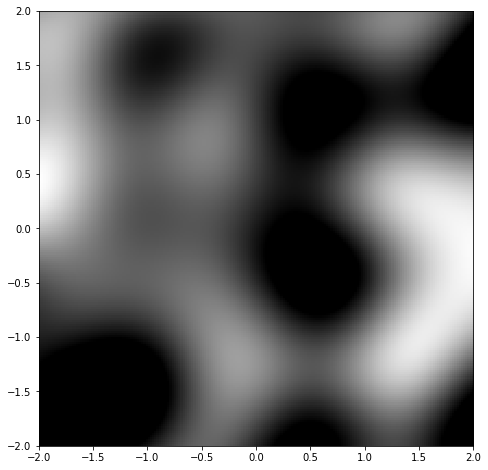

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(image4, extent=[min_val, max_val, min_val, max_val], interpolation="none")
plt.show()

Interpretation:
    
Aha! This looks pretty much like step (3), I would even go as far as it looks identically, given that
the stochastic nature of the beast obviously leads to 20 different centers than in our manual step (3).

#### Conclusion

[Random Kitchen Sinks](https://papers.nips.cc/paper/3182-random-features-for-large-scale-kernel-machines.pdf)
are for sure not equivalent to Radial Basis Functions. But as this experiment shows for the 2D space,
they are approximating them pretty well.

Skimming over the papers it appears to me, that the computational performance is much better than calculating
RBFs manually and this might have been the reason, why the scikit-learn team finally decided to settle for
Random Kitchen Sinks and still call them `RBFSampler`.